# Predicting Sea Levels
### Evaluate sea level rise over the next few years based on time-series analysis and Monte-Carlo simulation.

In [ ]:
# Set up notebook headers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier

%matplotlib inline
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'xgboost'

#### Data Collection
Read in an Excel file containing 5 sheets which have been compiled from various sources to reflect monthly measurements between June 2000 and July 2024:
- Sea Levels: Variation in sea levels (mm) relative to June 2000. Sourced from [NASA](https://climate.nasa.gov/vital-signs/sea-level/?intent=121).
- CO2 Levels: Concentration of carbon dioxide in the atmosphere (ppm). Sourced from [NASA](https://climate.nasa.gov/vital-signs/carbon-dioxide/?intent=121).
- Temperature: Average surface temperature (deg C). Sourced from [Our World in Data](https://ourworldindata.org/grapher/monthly-average-surface-temperatures-by-year)
- Ocean Warming: Energy stored in the oceans (ZJ) relative to June 2000. Sourced from [NASA](https://climate.nasa.gov/vital-signs/ocean-warming/?intent=121)
- Polar Mass: Variation of polar mass in Antarctica (billion tons) relative to June 2000. Sourced from [EPA](https://www.epa.gov/climate-indicators/climate-change-indicators-ice-sheets) 

Note that the Sea Levels, Ocean Warming, and Polar Mass datasets contain uncertainty values which will be useful when performing Monte-Carlo simulations.

In [2]:
dataset = pd.read_excel('C:\\Users\\rohit\\OneDrive\\2024\\Sea Level Predictions\\Project_Final.xlsx', 
                        sheet_name = ['Sea Levels', 'CO2 Levels', 'Temperature', 'Ocean Warming', 'Polar Mass'])

In [3]:
unified = pd.DataFrame()
unified.index = dataset['Sea Levels']['Date']
unified['Sea Levels'] = dataset['Sea Levels']['Relative Sea Level Since 2000 (mm)'].values
unified['CO2 Levels'] = dataset['CO2 Levels']['CO2 Concentration (ppm)'].values
unified['Temperature'] = dataset['Temperature']['Average Surface Temperature (deg C)'].values
unified['Ocean Warming'] = dataset['Ocean Warming']['Ocean Warming Relative to 2000 (ZJ)'].values
unified['Polar Mass'] = dataset['Polar Mass']['Antarctica Change in Mass Relative to 2000 (Gt)'].values

#### Visualise Raw Data
View some records in each table and plot them to highlight any key trends and/or outliers.

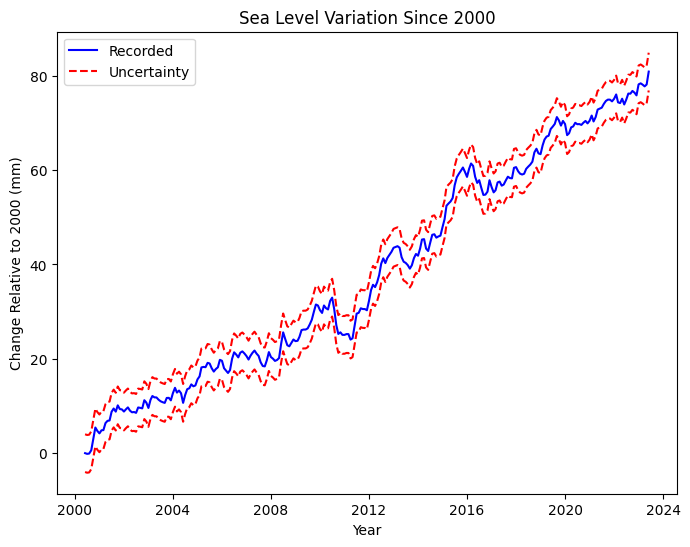

In [4]:
# Plot sea levels over time
plt.figure(figsize = (8, 6)) 
plt.plot(dataset['Sea Levels']['Date'], dataset['Sea Levels']['Relative Sea Level Since 2000 (mm)'], color = 'b',
         label = 'Recorded')
plt.plot(dataset['Sea Levels']['Date'], dataset['Sea Levels']['Lower Bound (mm)'], 
         linestyle = '--', color = 'r', label = 'Uncertainty')
plt.plot(dataset['Sea Levels']['Date'], dataset['Sea Levels']['Upper Bound (mm)'], 
         linestyle = '--', color = 'r')

plt.xlabel('Year')
plt.ylabel('Change Relative to 2000 (mm)')
plt.title('Sea Level Variation Since 2000')

plt.legend()

plt.show()

There is a general positive trend with regular fluctuations within each year and an irregular drop in 2011 and spike in 2016. Will require some decomposition to highlight any seasonal trends.

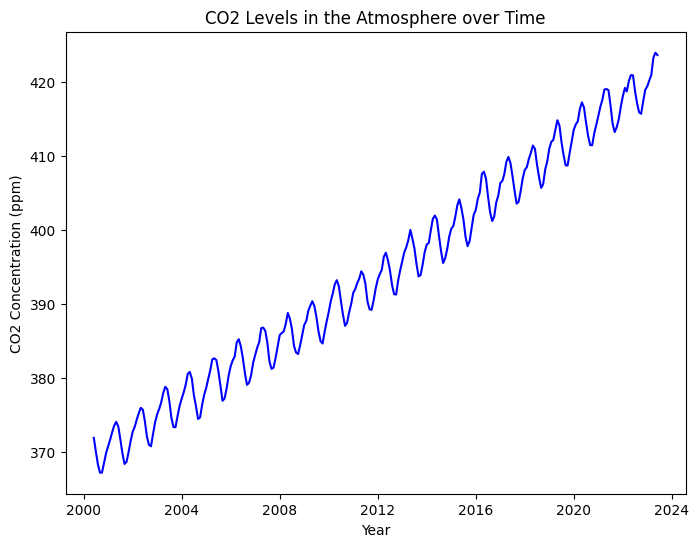

In [5]:
# Plot CO2 levels over time
plt.figure(figsize = (8, 6)) 
plt.plot(dataset['CO2 Levels']['Date'], dataset['CO2 Levels']['CO2 Concentration (ppm)'], color = 'b')

plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
plt.title('CO2 Levels in the Atmosphere over Time')

plt.show()

Clear positive trend with a yearly seasonal component that remains consistent throughout the entire period.

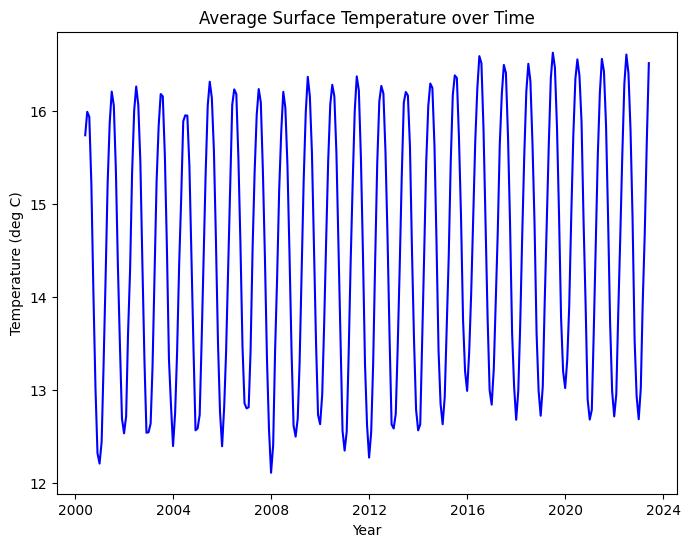

In [6]:
# Plot average temperature over time
plt.figure(figsize = (8, 6)) 
plt.plot(dataset['Temperature']['Date'], dataset['Temperature']['Average Surface Temperature (deg C)'], color = 'b')

plt.xlabel('Year')
plt.ylabel('Temperature (deg C)')
plt.title('Average Surface Temperature over Time')

plt.show()

Slightly positive trend as the yearly peaks seem to increase gradually over time, however may not be significant enough to align with sea level rise. Yearly seasonal component present as well.

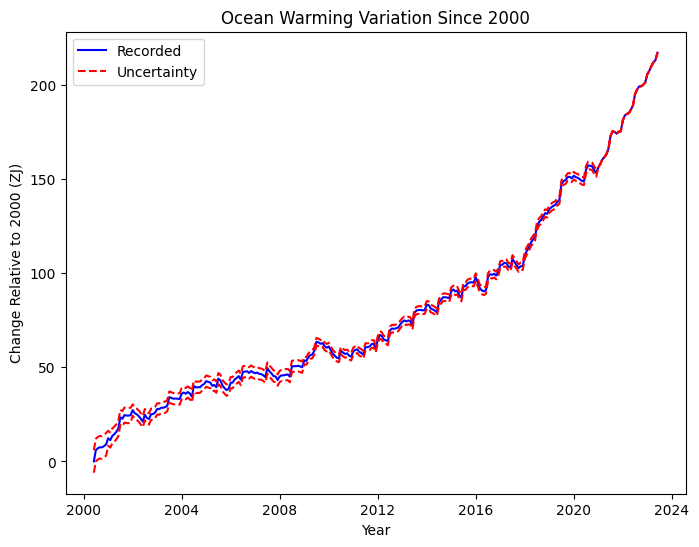

In [7]:
# Plot sea levels over time
plt.figure(figsize = (8, 6)) 
plt.plot(dataset['Ocean Warming']['Date'], dataset['Ocean Warming']['Ocean Warming Relative to 2000 (ZJ)'], color = 'b',
         label = 'Recorded')
plt.plot(dataset['Ocean Warming']['Date'], dataset['Ocean Warming']['Lower Bound (ZJ)'], 
         linestyle = '--', color = 'r', label = 'Uncertainty')
plt.plot(dataset['Ocean Warming']['Date'], dataset['Ocean Warming']['Upper Bound (ZJ)'], 
         linestyle = '--', color = 'r')

plt.xlabel('Year')
plt.ylabel('Change Relative to 2000 (ZJ)')
plt.title('Ocean Warming Variation Since 2000')

plt.legend()

plt.show()

General positive trend, with a marked increase in the gradient from 2018 onwards. Regular fluctuations indicate a yearly seasonal component, however further decomposition will be required to confirm this.

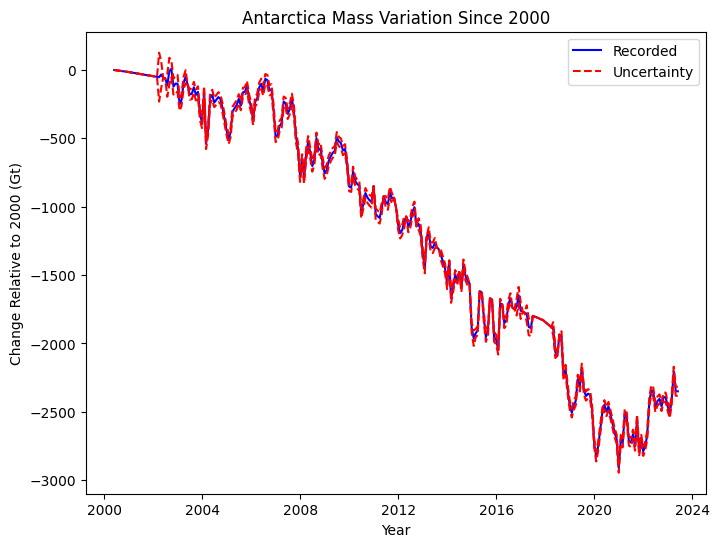

In [8]:
# Plot sea levels over time
plt.figure(figsize = (8, 6)) 
plt.plot(dataset['Polar Mass']['Date'], dataset['Polar Mass']['Antarctica Change in Mass Relative to 2000 (Gt)'], color = 'b',
         label = 'Recorded')
plt.plot(dataset['Polar Mass']['Date'], dataset['Polar Mass']['Lower Bound (Gt)'], 
         linestyle = '--', color = 'r', label = 'Uncertainty')
plt.plot(dataset['Polar Mass']['Date'], dataset['Polar Mass']['Upper Bound (Gt)'], 
         linestyle = '--', color = 'r')

plt.xlabel('Year')
plt.ylabel('Change Relative to 2000 (Gt)')
plt.title('Antarctica Mass Variation Since 2000')

plt.legend()

plt.show()

Clear negative trend over time with a slight increase between 2020 and 2023 which may impact its correlation with sea levels.

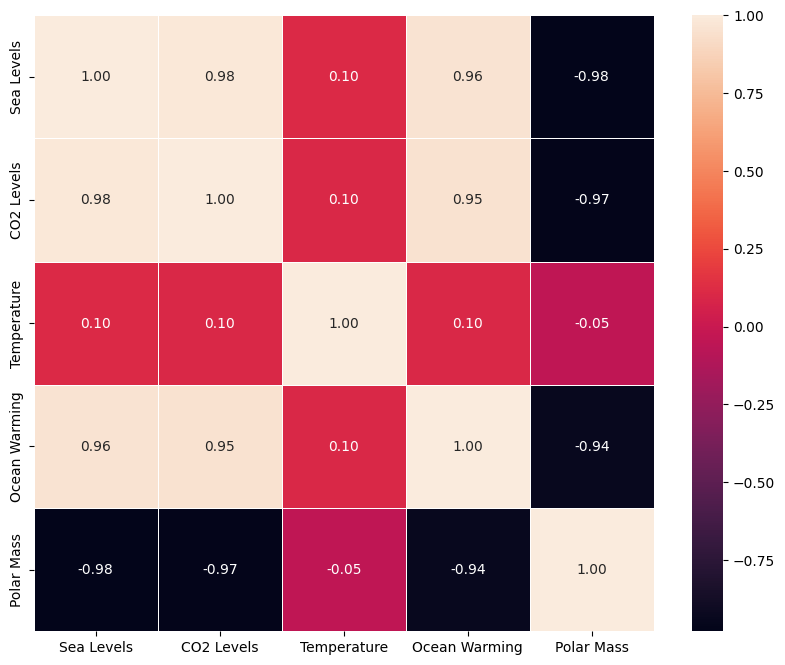

In [9]:
# See how well the "predictor" variables are correlated to sea level rise
corr = unified.corr(method = 'pearson')
 
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot = True, fmt = ".2f", linewidth = .5)
plt.show()

Looking at the first row, it is clear that CO2 levels, Ocean Warming, and Polar Mass are correlated significantly with sea levels, whilst Temperature has a weak relationship. Interesting to note that Ocean Warming and CO2 levels are also heavily correlated along with Polar Mass and Ocean Warming, and Polar Mass and CO2 Levels.

#### Time Series Analysis
Evaluate different time series models (ARIMA, SARIMA, LSTM, and Prophet) for forecasting sea level rise in the near future.

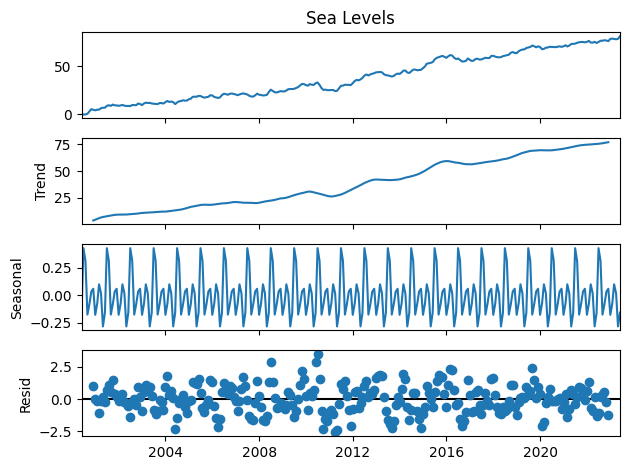

In [10]:
# Perform seasonal decomposition (must be additive as there are negative/zero values)
decomp = seasonal_decompose(unified['Sea Levels'], model= 'additive')
decomp.plot()

plt.show()

Decomposition of the sea levels dataset shows that there is a clear positive trend which is fairly linear. The seasonal component is consistent throughout the period (at a yearly frequency) and ther residuals are scattered evenly below and above the zero line.

In [11]:
# Check for stationarity using ADF test
results = adfuller(unified['Sea Levels'])
print('ADF Statistic:', results[0])
print('p-value:', results[1])
print('Critical Values:', results[2])

ADF Statistic: 0.3051036602075721
p-value: 0.9775774313703549
Critical Values: 10


P-value from the ADF test is well above the 0.05 significance level, thus we will need to apply a transform to achieve stationarity.

In [12]:
# Apply first-order differencing
unified['Sea Levels 1st Order'] = unified['Sea Levels'].diff()

In [13]:
# Check for stationarity using ADF test
results = adfuller(unified['Sea Levels 1st Order'].dropna())
print('ADF Statistic:', results[0])
print('p-value:', results[1])
print('Critical Values:', results[2])

ADF Statistic: -5.376838278230431
p-value: 3.788018635591683e-06
Critical Values: 9


P-value from the ADF test is well below the 0.05 significance level - we now have a stationary time series.

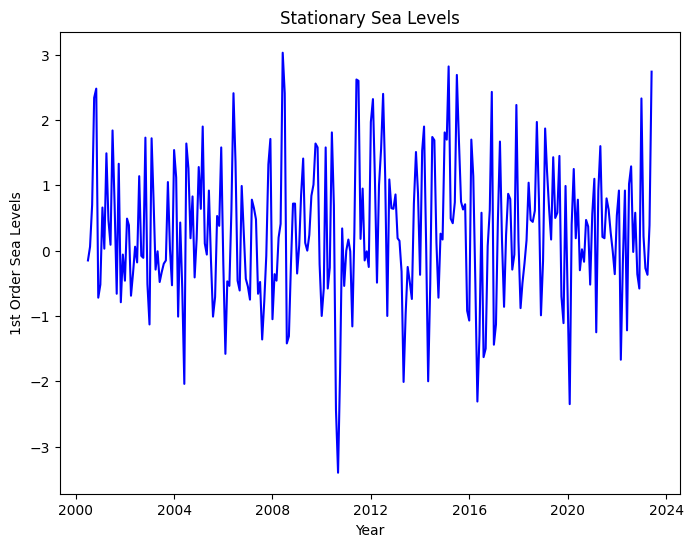

In [14]:
# Plot stationary time series
plt.figure(figsize = (8, 6)) 
plt.plot(unified.index, unified['Sea Levels 1st Order'], color = 'b')

plt.xlabel('Year')
plt.ylabel('1st Order Sea Levels')
plt.title('Stationary Sea Levels')

plt.show()

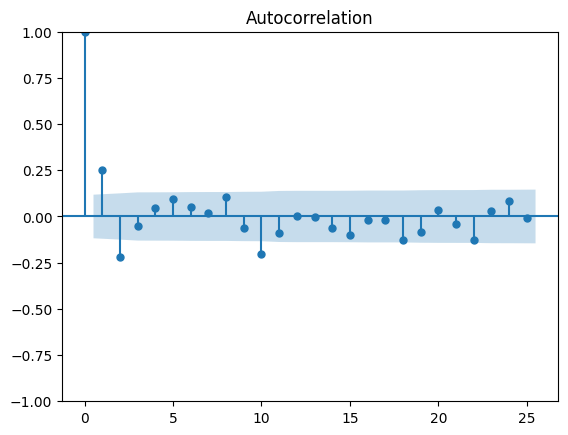

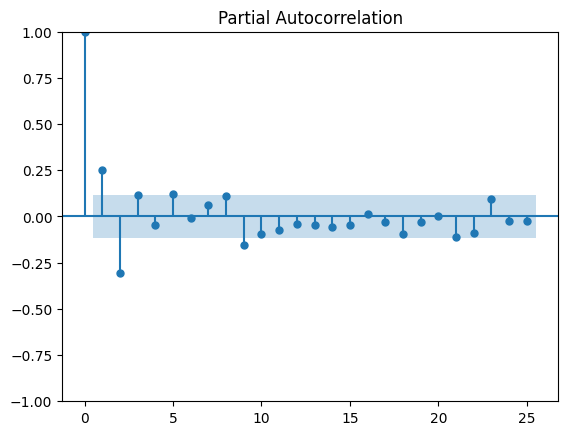

In [15]:
# Plot ACF and PACF
plot_acf(unified['Sea Levels 1st Order'].dropna())
plot_pacf(unified['Sea Levels 1st Order'].dropna(), method = 'ywm')
plt.show()

The ACF plot suggests that the 10th lag (p) is statistically signficant, whilst the PACF plot suggests it is the 9th lag (q). These values don't quite line up against our initial thoughts of a yearly seasonal component but are close enough. We will refer to these values for the ARIMA and SARIMA models below.

Let's create training and test sets for model evaluation.

In [16]:
# Create train/test split (85/15)
split = int(len(unified) * 0.85)
train = unified['Sea Levels 1st Order'][1:split].values
test = unified['Sea Levels 1st Order'][split:]

##### ARIMA

In [17]:
# Fit ARIMA model
arima_model = ARIMA(train, order = (10, 1, 9)).fit()

# Forecast using model
arima_forecast_diffs = arima_model.forecast(len(test))

# Apply forecasts to training set (they are currently 1st order differences so need to add them)
arima_forecasts = unified['Sea Levels'][:split]
for val_idx, time_idx in enumerate(test.index):
    arima_forecasts[time_idx] = arima_forecasts[-1] + arima_forecast_diffs[val_idx]

c:\Users\rohit\AppData\Local\conda\conda\envs\yolov7_custom\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\rohit\AppData\Local\conda\conda\envs\yolov7_custom\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\rohit\AppData\Local\conda\conda\envs\yolov7_custom\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rohit\AppData\Local\Temp\ipykernel_11060\4089634369.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will al

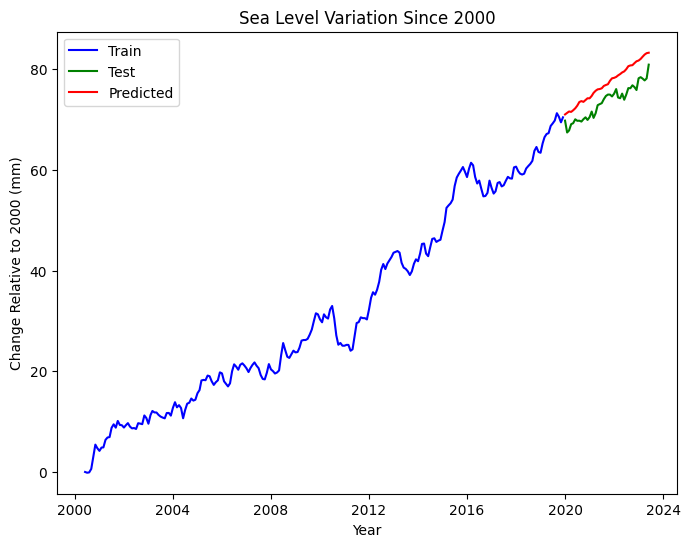

In [18]:
# Plot forecasted values and actual values
plt.figure(figsize = (8, 6)) 
plt.plot(unified.index[:split], unified['Sea Levels'][:split], color = 'b', label = 'Train')
plt.plot(unified.index[split:], unified['Sea Levels'][split:], color = 'g', label = 'Test')
plt.plot(arima_forecasts.index[split:], arima_forecasts.values[split:], color = 'r', label = 'Predicted')

plt.xlabel('Year')
plt.ylabel('Change Relative to 2000 (mm)')
plt.title('Sea Level Variation Since 2000')

plt.legend()

plt.show()

The forecasted values are higher than what actually occurred but overall captures the positive linear trend quite well. Lets quantify the strength of the predictions:

In [19]:
# Find MSE
print('MSE:', mean_squared_error(unified['Sea Levels'].values[split:], arima_forecasts.values[split:]))

MSE: 14.442829474267361


##### SARIMA

In [20]:
# Fit SARIMA model
sarima_model = ARIMA(train, order = (10, 1, 9), seasonal_order = (1, 1, 1, 12)).fit()

# Forecast using model
sarima_forecast_diffs = sarima_model.forecast(len(test))

# Apply forecasts to training set (they are currently 1st order differences so need to add them)
sarima_forecasts = unified['Sea Levels'][:split]
for val_idx, time_idx in enumerate(test.index):
    sarima_forecasts[time_idx] = sarima_forecasts[-1] + sarima_forecast_diffs[val_idx]

c:\Users\rohit\AppData\Local\conda\conda\envs\yolov7_custom\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rohit\AppData\Local\Temp\ipykernel_11060\2989822070.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sarima_forecasts[time_idx] = sarima_forecasts[-1] + sarima_forecast_diffs[val_idx]
C:\Users\rohit\AppData\Local\Temp\ipykernel_11060\2989822070.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sarima_forecasts[time_idx] = sarima_forecasts[-1] + s

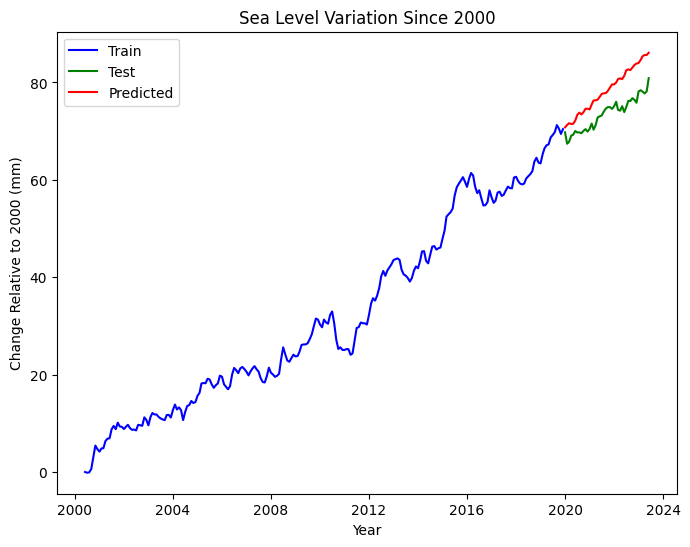

In [21]:
# Plot forecasted values and actual values
plt.figure(figsize = (8, 6)) 
plt.plot(unified.index[:split], unified['Sea Levels'][:split], color = 'b', label = 'Train')
plt.plot(unified.index[split:], unified['Sea Levels'][split:], color = 'g', label = 'Test')
plt.plot(sarima_forecasts.index[split:], sarima_forecasts.values[split:], color = 'r', label = 'Predicted')

plt.xlabel('Year')
plt.ylabel('Change Relative to 2000 (mm)')
plt.title('Sea Level Variation Since 2000')

plt.legend()

plt.show()

The forecasted values are once again a lot higher than the actual values, but in this case the two lines diverge implying that predictions made well into the future would be quite off. Lets quantify the strength of the predictions:

In [22]:
# Find MSE
print('MSE:', mean_squared_error(unified['Sea Levels'].values[split:], sarima_forecasts.values[split:]))

MSE: 27.07202514386406


##### LSTM

In [23]:
# Normalize the data to the range (0, 1)
data = unified['Sea Levels'].values
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

# Create sequences for the LSTM model
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])  
        y.append(data[i + time_step, 0])  
    return np.array(X), np.array(y)

time_step = 12  # Number of previous time steps to predict the next value
X, y = create_dataset(scaled_data, time_step)

# Reshape X to 3D array
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into train and test sets
X_train, X_test = X[:split - time_step], X[split - time_step:]
y_train, y_test = y[:split - time_step], y[split - time_step:]

# Fit LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences = False, input_shape = (X_train.shape[1], 1)))
lstm_model.add(Dense(units = 1))  
lstm_model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mean_squared_error')
lstm_model_fit = lstm_model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data = (X_test, y_test), 
                         verbose = 1)

# Forecast using model
lstm_forecasts = scaler.inverse_transform(lstm_model.predict(X_test))



Epoch 1/100

7/7 [==============================] - 4s 168ms/step - loss: 0.0806 - val_loss: 0.1170
Epoch 2/100
7/7 [==============================] - 0s 34ms/step - loss: 0.0100 - val_loss: 0.0039
Epoch 3/100
7/7 [==============================] - 0s 26ms/step - loss: 0.0117 - val_loss: 0.0011
Epoch 4/100
7/7 [==============================] - 0s 19ms/step - loss: 0.0036 - val_loss: 0.0141
Epoch 5/100
7/7 [==============================] - 0s 21ms/step - loss: 0.0041 - val_loss: 0.0143
Epoch 6/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 7/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0017 - val_loss: 3.5442e-04
Epoch 8/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 4.5970e-04
Epoch 9/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 9.9108e-04
Epoch 10/100
7/7 [==============================] - 0s 20ms/step - loss: 0.0010 - val_loss: 2.3045e-04


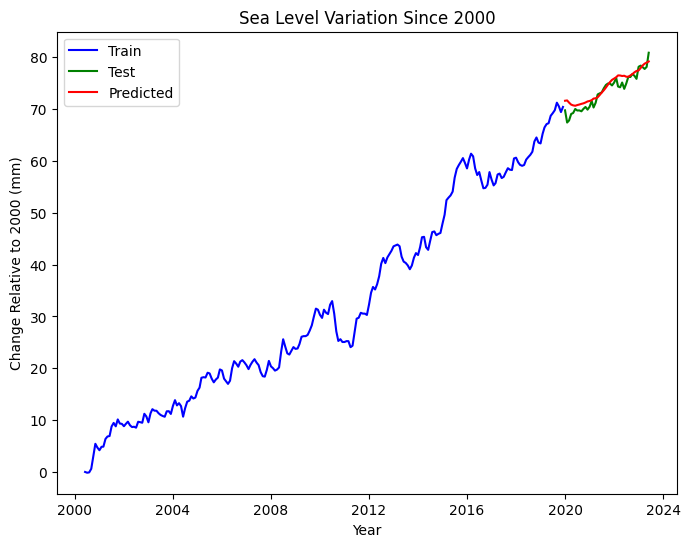

In [24]:
# Plot forecasted values and actual values
plt.figure(figsize = (8, 6)) 
plt.plot(unified.index[:split], unified['Sea Levels'][:split], color = 'b', label = 'Train')
plt.plot(unified.index[split:], unified['Sea Levels'][split:], color = 'g', label = 'Test')
plt.plot(unified.index[split:], lstm_forecasts, color = 'r', label = 'Predicted')

plt.xlabel('Year')
plt.ylabel('Change Relative to 2000 (mm)')
plt.title('Sea Level Variation Since 2000')

plt.legend()

plt.show()

The overall trend is captured extremely well by the forecasted values. Whilst small fluctuations aren't captured, the model does a great job at projecting past values into the future. Lets quantify the strength of the predictions:

In [25]:
# Find MSE
print('MSE:', mean_squared_error(unified['Sea Levels'].values[split:], lstm_forecasts))

MSE: 1.9887440836669692


##### Prophet

In [26]:
# Prepare dataset to pass into model
prophet_data = unified.reset_index()
prophet_data = prophet_data[1:split][['Date', 'Sea Levels']]
prophet_data = prophet_data.rename(columns = {'Date': 'ds', 'Sea Levels': 'y'})
prophet_data['ds'] = pd.to_datetime(prophet_data['ds'])

# Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Make dataframe for future values
future = prophet_model.make_future_dataframe(prophet_data, periods = len(test), freq = 'M')

# Forecast using model
prophet_forecasts = prophet_model.predict(future)

20:30:12 - cmdstanpy - INFO - Chain [1] start processing
20:30:12 - cmdstanpy - INFO - Chain [1] done processing
20:30:12 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 
Optimization terminated abnormally. Falling back to Newton.
20:30:12 - cmdstanpy - INFO - Chain [1] start processing
20:30:13 - cmdstanpy - INFO - Chain [1] done processing
20:30:13 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 3221225657 


RuntimeError: Error during optimization! Command 'C:\Users\rohit\AppData\Local\conda\conda\envs\yolov7_custom\Lib\site-packages\prophet\stan_model\prophet_model.bin random seed=27729 data file=C:\Users\rohit\AppData\Local\Temp\tmp3az9oej9\vy8nfx_5.json init=C:\Users\rohit\AppData\Local\Temp\tmp3az9oej9\5_0sbz2q.json output file=C:\Users\rohit\AppData\Local\Temp\tmp3az9oej9\prophet_modelepf8euy8\prophet_model-20250207203012.csv method=optimize algorithm=newton iter=10000' failed: 

In [ ]:
# Plot forecasted values and actual values
plt.figure(figsize = (8, 6)) 
plt.plot(unified.index[:split], unified['Sea Levels'][:split], color = 'b', label = 'Train')
plt.plot(unified.index[split:], unified['Sea Levels'][split:], color = 'g', label = 'Test')
plt.plot(unified.index[split:], prophet_forecasts, color = 'r', label = 'Predicted')

plt.xlabel('Year')
plt.ylabel('Change Relative to 2000 (mm)')
plt.title('Sea Level Variation Since 2000')

plt.legend()

plt.show()

#### Regression 
Build a regression model to find a relationship between the various enviromental factors and sea levels. This will be used to generate predictions for sea levels based on the uncertainty levels of the factors.

In [ ]:
# Fit XGBoost model
xg_model = XGBClassifier(n_estimators = 2, max_depth = 2, learning_rate = 1, objective = 'binary:logistic')
xg_model.fit()